# Data Preparing and loading

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# create some data
weight = 0.7
bias = 0.3

# create data
X = torch.linspace(0.,1.,50).unsqueeze(dim=1)
y = weight * X + bias

In [3]:
X.shape,y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [4]:
# split the data
train_split = int(0.8 * len(X))

X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:] ,y[train_split:]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [5]:
def plot_predictions(train_data_,train_labels_,test_data_,test_labels_,prediction_=None):
    plt.figure(figsize=(4,3))
    plt.scatter(train_data_,train_labels_,label="Training Data")
    plt.scatter(test_data_,test_labels_,label="Testing data")
    if prediction_ is not None:
        plt.scatter(test_data_,prediction_,label="Prediction")
    plt.legend()
    plt.show()

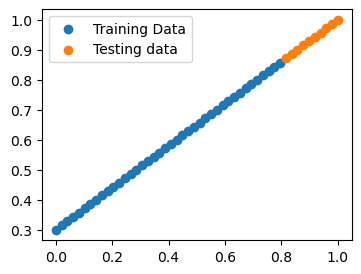

In [6]:
plot_predictions(X_train,y_train,X_test,y_test)

# Build the model

Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator.

In [7]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,requires_grad=True,
                                               dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1,requires_grad=True,
                                            dtype=torch.float32))

    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.weights * x + self.bias

## View the parameter

In [8]:
torch.manual_seed(42)

model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# we can see the named parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
model_0.weights

Parameter containing:
tensor([0.3367], requires_grad=True)

## Making prediction using `torch.inference_mode()`

In [11]:
with torch.inference_mode():
    y_pred = model_0(X_test)

y_pred

tensor([[0.4037],
        [0.4105],
        [0.4174],
        [0.4243],
        [0.4311],
        [0.4380],
        [0.4449],
        [0.4518],
        [0.4586],
        [0.4655]])

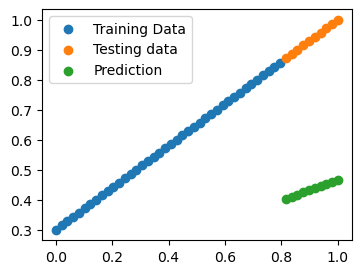

In [12]:
plot_predictions(X_train,y_train,X_test,y_test,y_pred)

**what is special about the inference mode?**
1. it disables the autograd mechanism.
2. So it speed up the process.

**Disadvantage:**
1. Inference tensor cant be used outside  InferenceMode for autograd operation.
2. Inference tenor cant be modified inplace operation outside the inference mode.

In [13]:
# without inference mode , pytorch track the autograd
model_0(X_test)
#? you can see the grad function

tensor([[0.4037],
        [0.4105],
        [0.4174],
        [0.4243],
        [0.4311],
        [0.4380],
        [0.4449],
        [0.4518],
        [0.4586],
        [0.4655]], grad_fn=<AddBackward0>)

In [14]:
# cant use outside the inference context
with torch.inference_mode():
    a = torch.rand(1)

b = torch.rand(2,requires_grad=True)
try:
    a*b
except RuntimeError as err:
    print(err)

Inference tensors cannot be saved for backward. To work around you can make a clone to get a normal tensor and use it in autograd.


In [15]:
b * a.clone()

tensor([0.2346, 0.1002], grad_fn=<MulBackward0>)

In [16]:
# cant perform the inplace operation
with torch.inference_mode():
    a = torch.rand(1)

try:
    a += a
except RuntimeError as err:
    print(err)

Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.


# Train Model

Thing we need to train :
1. **Loss Function :** A function to measure how wrong your model prediction are to ideal output.
2. **Optimiser :** Take into account of the loss of model , and learn more about the data , by updating the parameters.

For pytorch:
* a training loop
* a testing loop

## Setup loss function

In [17]:
loss_fn = nn.L1Loss()

## Set optimizer

In [18]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

## Building the triangle loop
1. Loop through the data.
2. Forward pass
3. Calculate loss
4. Backpropagation the error
5. update the parameter using the gradient descent

In [19]:
# num of epochs
epochs = 100

# 1. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    # pytorch set all the parameter that require for gradient
    model_0.train()

    # 2. forward pass
    y_pred = model_0(X_train)

    # 3. Calculate the loss
    loss = loss_fn(y_pred,y_train)

    #! 4. optimiser zero grad
    optimizer.zero_grad()

    # 4. back propagate the errors
    loss.backward()

    # 5. update teh parameter using the gradient decent
    optimizer.step()
    #! by default how the optimiser change will accumulate change through the loop, we have to zero them before backpropagation to error.


    # return the gradient tracking
    model_0.eval() # turn off the dropout / batch normalization
    with torch.inference_mode():
        # 1. do the forward pass
        test_pred = model_0(X_test)
        # 2. calculate the test loss
        test_loss = loss_fn(test_pred,y_test)

    # print what happening
    if (epoch+1) % 10 == 0:
        print(f'Epoch :{epoch}  | Loss : {loss.item():.6f}  | Test loss : {test_loss.item():.6f}')
        print(model_0.state_dict())


Epoch :9  | Loss : 0.211520  | Test loss : 0.364994
OrderedDict([('weights', tensor([0.3765])), ('bias', tensor([0.2288]))])
Epoch :19  | Loss : 0.098487  | Test loss : 0.231917
OrderedDict([('weights', tensor([0.4162])), ('bias', tensor([0.3258]))])
Epoch :29  | Loss : 0.055434  | Test loss : 0.151549
OrderedDict([('weights', tensor([0.4508])), ('bias', tensor([0.3748]))])
Epoch :39  | Loss : 0.046278  | Test loss : 0.116373
OrderedDict([('weights', tensor([0.4757])), ('bias', tensor([0.3873]))])
Epoch :49  | Loss : 0.042223  | Test loss : 0.100580
OrderedDict([('weights', tensor([0.4953])), ('bias', tensor([0.3853]))])
Epoch :59  | Loss : 0.038608  | Test loss : 0.089594
OrderedDict([('weights', tensor([0.5135])), ('bias', tensor([0.3798]))])
Epoch :69  | Loss : 0.035052  | Test loss : 0.081387
OrderedDict([('weights', tensor([0.5308])), ('bias', tensor([0.3723]))])
Epoch :79  | Loss : 0.031496  | Test loss : 0.072484
OrderedDict([('weights', tensor([0.5483])), ('bias', tensor([0.365

# Load and saving

There are three main methods for saving and loading the model

1. `torch.save()` - save the model using the pickle.
2. `torch.load()` - load the model
3. `torch.nn.Module.load_state_dict()` - allows to load teh model saved state dictionary.

## Saving the model state dict

In [20]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path
MODEl_NAME = "02_workflow_model_0_state_dict.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEl_NAME

# 3. Save the model state
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

## Load the model save dict
Since we save the model state dict , so we have to create instance of the model and we have to load the model state dict to save dict.

In [21]:
load_model_0  = LinearRegression()
load_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
load_model_0.eval()
with torch.inference_mode():
    print(f"Training Loss : {nn.L1Loss()(load_model_0(X_train),y_train)}")
    print(f"Testing  Loss : {nn.L1Loss()(load_model_0(X_test),y_test)}")

Training Loss : 0.024035830050706863
Testing  Loss : 0.056069474667310715


## Saving the whole model

In [24]:
MODEl_NAME = "02_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEl_NAME

torch.save(obj=model_0,
           f=MODEL_SAVE_PATH)

## Loading the whole model

Since we save eh whole model , there is no need to crete the instance of the model.

In [25]:
load_model_0 = torch.load(f=MODEL_SAVE_PATH)
load_model_0.eval()

with torch.inference_mode():
    print(f"Training Loss : {nn.L1Loss()(load_model_0(X_train),y_train)}")
    print(f"Testing  Loss : {nn.L1Loss()(load_model_0(X_test),y_test)}")

Training Loss : 0.024035830050706863
Testing  Loss : 0.056069474667310715


# Putting all together

In [29]:
import torch
from torch import nn
import matplotlib.pyplot as plt


## Create device agnostic code

In [27]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using Device : {device}')

using Device : cpu


## Data

In [30]:
# data for the linear regression
weight = 0.7
bias = 0.3

# create the dummy data
X = torch.linspace(start=0.0,end=1.0,steps=50).unsqueeze(dim=1)
y = weight * X + bias

X.shape,y.shape


(torch.Size([50, 1]), torch.Size([50, 1]))

In [32]:
train_size = int(0.8 * len(X))

X_train ,X_test = X.split(train_size)
y_train,y_test = y.split(train_size)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

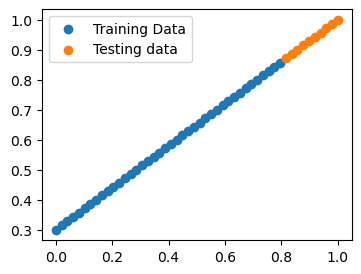

In [33]:
# plot the data
plot_predictions(X_train,y_train,X_test,y_test)

## Build the model

In [48]:
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use the nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1,
                                      bias=True)
    def forward(self,x:torch.Tensor)->torch.Tensor:
        return self.linear_layer(x)

In [49]:
# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1 ,model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [50]:
list(model_1.parameters())[0].device

device(type='cpu')

In [51]:
# set the model to target device
model_1.to(device)

LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

## Training the model

In [52]:
# setting the loss function
loss_fn = nn.L1Loss()

# setting the optimiser
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [53]:
from  collections import defaultdict
# training loop
torch.manual_seed(42)

epochs = 200

# put the data into the device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# store the loss during the epoch
history = defaultdict(list)

for epoch in range(epochs):
    # set the model in train mode
    model_1.train()

    # forward pass
    y_pred = model_1(X_train)

    # calculate the loss
    loss = loss_fn(y_pred,y_train)

    # set the optimizer zero grad
    optimizer.zero_grad()

    # back propagate
    loss.backward()

    # update the weights
    optimizer.step()

    ### Testing loops
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred,y_test)

    if (epoch+1) % 10 == 0:
        history["epoch"].append(epoch)
        history["train_loss"].append(loss.item())
        history["test_loss"].append(test_loss.item())
        print(f"Epoch: {epoch} | Train Loss : {loss.item():.6f} | Test Loss : {test_loss.item():.6f}")

Epoch: 9 | Train Loss : 0.451438 | Test Loss : 0.452479
Epoch: 19 | Train Loss : 0.335601 | Test Loss : 0.316338
Epoch: 29 | Train Loss : 0.219764 | Test Loss : 0.180197
Epoch: 39 | Train Loss : 0.103928 | Test Loss : 0.044056
Epoch: 49 | Train Loss : 0.025611 | Test Loss : 0.048302
Epoch: 59 | Train Loss : 0.021157 | Test Loss : 0.048532
Epoch: 69 | Train Loss : 0.017601 | Test Loss : 0.040325
Epoch: 79 | Train Loss : 0.014045 | Test Loss : 0.032117
Epoch: 89 | Train Loss : 0.010489 | Test Loss : 0.023910
Epoch: 99 | Train Loss : 0.006933 | Test Loss : 0.015702
Epoch: 109 | Train Loss : 0.003380 | Test Loss : 0.006800
Epoch: 119 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 129 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 139 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 149 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 159 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 169 | Train Loss : 0.009001 | Test Loss : 0.000755
Epoch: 179 | Train Loss :

In [54]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6964]])),
             ('linear_layer.bias', tensor([0.3040]))])

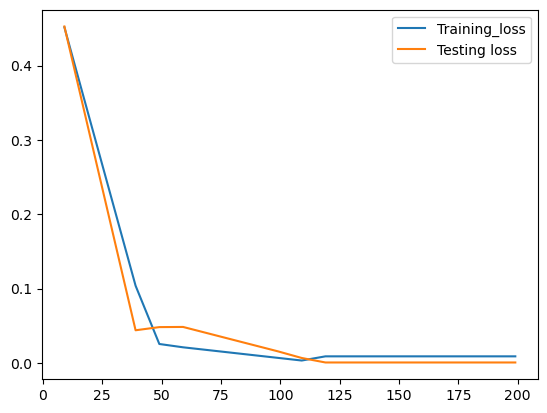

In [56]:
plt.plot(history["epoch"],history["train_loss"],label="Training_loss")
plt.plot(history["epoch"],history["test_loss"],label="Testing loss")
plt.legend()

## Saving and Loading model

In [58]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEl_NAME = "02_workflow_model_02.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEl_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [61]:
# load the model
load_model_1 = LinearRegressionV2()

load_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH,map_location=torch.device(device)))


model_1.eval()
load_model_1.eval()
with torch.inference_mode():
    print(f"Original Model : \n\tTraining Loss :{nn.L1Loss()(model_1(X_train),y_train):.6f}\n\tTesting Loss:{nn.L1Loss()(model_1(X_test),y_test):.6f}")
    print(f"Loaded Model : \n\tTraining Loss :{nn.L1Loss()(load_model_1(X_train),y_train):.6f}\n\tTesting Loss:{nn.L1Loss()(load_model_1(X_test),y_test):.6f}")

Original Model : 
	Training Loss :0.002583
	Testing Loss:0.000755
Loaded Model : 
	Training Loss :0.002583
	Testing Loss:0.000755
